In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

2024-03-01 07:24:15.933564: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 07:24:16.042676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 07:24:16.042696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 07:24:16.066570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 07:24:16.101552: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define notebook constants
DATASET_FILEPATH = "./dataset/mc-chic1.csv"

## **Loading in dataset & data exploration**

In [3]:
# Parse and read csv as a dataframe
dataframe = pd.read_csv(DATASET_FILEPATH, delimiter=",", header=0, index_col=0)
# Print out head of our dataframe to performa a sanity check
dataframe.head(10)

,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373
5,0.004481,4.217176,66.163826,0.097564,1.0,1.950114,-66.163826,0.029347,0.002872,-8.0373
6,0.005919,3.916690,8.657219,-0.134673,1.0,0.344540,8.657219,0.039469,-0.005348,-8.0373
7,0.003588,3.434997,4.931572,0.270846,1.0,0.317515,-4.931572,0.062166,0.017262,-8.0373
8,0.004865,3.561846,39.078457,1.871018,1.0,2.216805,39.078457,-0.016803,0.054277,-81.6274
9,0.006025,3.624830,104.407350,0.962990,1.0,5.561719,-104.407350,0.030464,0.043791,-81.6274


In [4]:
# Print out number of NANs in each column
print(f"{'#'*5} NUMBER OF NANs {'#'*5}")
print(dataframe.isna().sum())
print("\n")

# Check the values of polarity to cvheck if they are integer numbers
print(f"{'#'*5} POLARITY VALUES {'#'*5}")
print(np.unique(dataframe["pol"]))
print("\n")

# Print our a description of our dataframe to continue sanity check
print(f"{'#'*5} DATAFRAME DESCRIPTION {'#'*5}")
dataframe.describe()

##### NUMBER OF NANs #####
ep     0
eta    0
p      0
phi    0
pol    0
pt     0
qp     0
tx     0
ty     0
zV     0
dtype: int64


##### POLARITY VALUES #####
[-1.  1.]


##### DATAFRAME DESCRIPTION #####


,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
count,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000,208984.000000
mean,0.004582,3.536235,38.009716,0.020532,-0.013015,2.057444,-0.057122,-0.000804,0.000338,-3.537095
std,0.001043,0.535136,46.989681,1.781738,0.999918,2.188101,60.438169,0.050532,0.058026,40.933908
min,0.002469,1.817449,2.984704,-3.140953,-1.000000,0.182415,-1121.218000,-0.261077,-0.260077,-177.157300
25%,0.003846,3.153929,8.014261,-1.572803,-1.000000,0.466294,-18.415584,-0.032667,-0.038117,-30.886000
50%,0.004337,3.530497,18.407946,0.087080,-1.000000,1.100179,-0.000750,-0.000798,0.002586,-3.441400
75%,0.005027,3.922414,51.289614,1.601350,1.000000,3.103085,18.401911,0.031472,0.038615,23.986100
max,0.029343,5.096044,1121.218000,3.141593,1.000000,33.016370,846.472400,0.290477,0.258590,162.495500


As we can see from above, there are no NANs in the dataframe and each column contains the same number of counts.

We also see that the ranges for the datapoints in each column are realistic, with the angular data ranging from [$-\pi$, $\pi$], contunous data ranging from beliavable values and polarity ranging from the interger values -1 and 1.

Below we look to reproduce the plot from figure 1 in the lecture notes

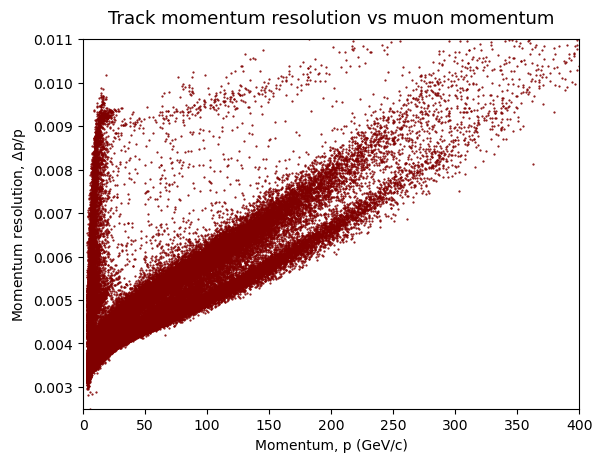

In [5]:
# Define limits of plot 
x_limit = (0, 400)
y_limit = (2.5e-3, 1.1e-2)

# Plot resolution track momentum resolution as function of momentum
plt.scatter(dataframe["p"], dataframe["ep"], s=0.3, c="maroon")
plt.xlabel("Momentum, p (GeV/c)")
plt.ylabel(r"Momentum resolution, $\Delta$p/p")
plt.title("Track momentum resolution vs muon momentum", y=1.02, fontsize=13)
plt.xlim(x_limit)
_=plt.ylim(y_limit)

# **Demonstrating $p_T << p_z$**

We first create numpy array containing the variables we look to append later to the dataframe

In [6]:
# Calcutale the z component of momentum
pz = np.sqrt(dataframe["p"]**2 - dataframe["pt"]**2)

# Calculate the error for the z component of the momentum for the muon trakc fit
epz = dataframe["ep"] * (dataframe["p"] / pz)

# Check there are no nans in the calculated data
print(f"Does pz contain NaNs?:    {np.any(np.isnan(pz))}")
print(f"Does epz contain NaNs?:   {np.any(np.isnan(epz))}\n")

# Append both variables to dataframe
dataframe["pz"] = pz
dataframe["epz"] = epz

# Print out head to check variables were appended 
dataframe.head(10)

Does pz contain NaNs?:    False
Does epz contain NaNs?:   False



,ep,eta,p,phi,pol,pt,qp,tx,ty,zV,pz,epz
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975,71.845851,0.005477
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975,37.627791,0.004052
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975,18.536851,0.003908
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975,8.617790,0.003866
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373,43.242050,0.004989
5,0.004481,4.217176,66.163826,0.097564,1.0,1.950114,-66.163826,0.029347,0.002872,-8.0373,66.135081,0.004483
6,0.005919,3.916690,8.657219,-0.134673,1.0,0.344540,8.657219,0.039469,-0.005348,-8.0373,8.650360,0.005923
7,0.003588,3.434997,4.931572,0.270846,1.0,0.317515,-4.931572,0.062166,0.017262,-8.0373,4.921340,0.003595
8,0.004865,3.561846,39.078457,1.871018,1.0,2.216805,39.078457,-0.016803,0.054277,-81.6274,39.015530,0.004873
9,0.006025,3.624830,104.407350,0.962990,1.0,5.561719,-104.407350,0.030464,0.043791,-81.6274,104.259110,0.006034


We now create the plots which are requested by the lecture notes

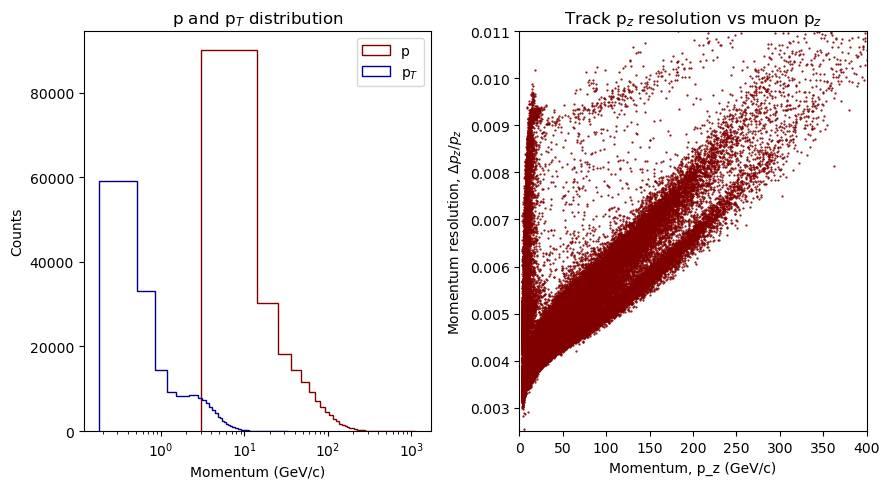

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

# Plot the pt and p 1d distributions
ax1.hist(dataframe["p"], 100, color="maroon", label="p", histtype="step")
ax1.hist(dataframe["pt"], 100, color="darkblue", label=r"p$_T$", histtype="step")
ax1.set(
    ylabel = "Counts",
    xlabel = "Momentum (GeV/c)",
    xscale = "log",
    title = r"p and p$_T$ distribution"
)
ax1.legend()

# Plot the z component momentum resolution distribution
ax2.scatter(pz, epz, s=0.3, color="maroon")
ax2.set(
    xlabel = r"Momentum, p_z (GeV/c)",
    ylabel = r"Momentum resolution, $\Delta p_z$/$p_z$",
    title = r"Track p$_z$ resolution vs muon p$_z$",
    xlim = x_limit,
    ylim = y_limit
)
fig.tight_layout()

From the plots above, we can easily see that the value of the $p_T$ parameters are $~ \mathcal{O}(10)$ smaller than the value of the momentum parameters.

Similarly, we see that the distribution for $\frac{\Delta p_z}{p_z}$ vs $p_z$ is similar to that of $\frac{\Delta p_z}{p}$

# **Regression with TF networks**

We will now create multiple networks which will look to predict the **$\frac{\Delta p}{p}$** using the following features as an input: **p, tx, ty, eta, phi**

Now we create a simple dense neural network with no hidden layers:

In [14]:
def create_simple_dense(input_features, output_features, loss="mean_squared_error", optimizer="adam"):
    """
    Create a simple two layer dense neural network w/ no hidden layers
    """
    # Create network
    network = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_features, input_dim=input_features, kernel_initializer="normal"),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_features, kernel_initializer="normal"),
    ])

    # Compile and return network
    network = network.compile(loss=loss, optimizer=optimizer)
    return network

# Define network parameters
input_features  = 5
output_features = 1
epochs          = 20
batch_size      = 265
seed            = 42
mean            = 0.0
std             = 0.3

# Set seed for reproducibility
np.random.seed(seed)

# Create network instance 
network = create_simple_dense(input_features, output_features)

# Create standard scaler object instance
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)

We will start by creating out input data and target numpy arrays, as well as applying some preprocessing steps to improve the network performance

In [13]:
# Define dataframe keys which will be used for input and target data
input_keys = ["p", "tx", "ty", "eta", "phi"]
target_keys = ["ep"]

# Generate input and target arrays
input_data = dataframe[input_keys].to_numpy()
target_data = dataframe[target_keys].to_numpy()

# Chech data array shapes
print(f"Input data:     {input_data.shape}")
print(f"Target data:    {target_data.shape}")

# Standardise the data
input_data = scaler.fit_transform(input_data)
# Print mean and std of sclaed data
print(f"Mean of input data: {scaler.mean_} \nVar of input data: {scaler.var_}")
target_data = scaler.fit_transform(target_data)
print(f"Mean of input data: {scaler.mean_} \nVar of input data: {scaler.var_}")

Input data:     (208984, 5)
Target data:    (208984, 1)
Mean of input data: [ 3.80097163e+01 -8.04309226e-04  3.37676782e-04  3.53623546e+00
  2.05323349e-02] 
Var of input data: [2.20801955e+03 2.55343731e-03 3.36703034e-03 2.86368719e-01
 3.17457594e+00]
Mean of input data: [0.00458198] 
Var of input data: [1.08784242e-06]


We now train the simple dense network to predict the $\frac{\Delta p_z}{p_z}$ for each track